# Импорты

Импорт всех необходимых библиотек

In [9]:
%pip install -q catboost
%pip install -q optuna


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [10]:
%pip install -q shap


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFClassifier
from sklearn.model_selection import cross_validate, cross_val_score
from shap import TreeExplainer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [85]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

In [13]:
import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from optuna.samplers import RandomSampler, TPESampler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
import catboost

In [14]:
import warnings
warnings.filterwarnings("ignore")

Импорт датасета

In [15]:
df = pd.read_csv('db_subset.csv')
df

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,0.04,0.93,NaN,NaN,0.75,0.08,378.50,NaN,NaN,0.32,19.83,2.25,NaN,NaN,NaN,28.18,0.04,26.83,NaN,8.00,0.06,0.05,0.03,0.04,49.00,NaN,NaN,NaN,NaN,NaN,33.75,0.02,NaN,NaN,0.72,0.06,NaN,NaN,50.00,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,0.66,0.11,NaN,NaN,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,0.02,0.66,NaN,NaN,0.64,0.05,324.95,NaN,NaN,0.19,15.86,0.94,NaN,NaN,NaN,17.79,0.02,23.26,NaN,4.80,0.04,0.06,0.05,0.02,45.40,NaN,NaN,NaN,NaN,NaN,26.08,0.01,NaN,NaN,0.48,0.04,NaN,NaN,30.00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,1.12,0.11,NaN,NaN,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,0.04,1.11,NaN,NaN,1.00,0.08,354.73,NaN,NaN,0.34,25.80,4.77,NaN,NaN,NaN,28.46,0.04,29.70,NaN,8.83,0.07,0.03,0.02,0.05,37.83,NaN,NaN,NaN,NaN,NaN,35.00,0.02,NaN,NaN,0.73,0.06,NaN,NaN,53.22,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,0.11,0.10,NaN,NaN,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,0.03,0.14,0.01,0.01,0.02,0.01,2.45,NaN,0.01,0.22,0.12,NaN,NaN,NaN,0.01,NaN,0.02,0.19,NaN,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.43,NaN,NaN,0.01,1.45,0.00,NaN,0.00,0.02,0.01,NaN,0.01,NaN,0.01,0.00,0.00,0.00,NaN,0.01,NaN,NaN,0.01,0.04,NaN,0.01,NaN,0.00,0.00,NaN,NaN,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,0.05,0.33,0.03,0.02,0.02,0.00,5.97,NaN,0.02,0.10,0.20,NaN,NaN,NaN,0.02,NaN,0.05,0.40,NaN,0.09,0.00,0.00,0.00,0.00,0.10,0.03,0.82,NaN,NaN,0.04,3.32,0.00,NaN,0.01,0.05,0.00,NaN,0.02,NaN,0.02,NaN,0.01,0.00,NaN,0.02,NaN,NaN,0.03,0.07,NaN,0.02,0.01,0.00,0.00,NaN,NaN,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,10.50,55.08,1.96,1.71,11.42,5.57,2305.47,17.34,0.88,56.86,760.68,2.33,0.60,15.07,1.44,163.39,9.33,217.28,8.92,466.08,1.00,1.51,2.84,0.95,218.19,3.14,182.73,62.20,0.02,2.45,961.52,0.84,0.02,0.81,11.14,4.89,0.01,1.30,109.94,1.30,1.29,0.38,3.59,60.64,1.41,0.88,6.67,2.51,10.56,181.60,113.14,4.17,4.55,0.73,9.21,24.18,60.15,68.55,6.56,4.58,1,0,0,1,35.986159,0
2881,36.1,77.1,51.6,1867.95,34.70,3373.56,81.50,2929.34,3550.36,20.59,32.17,185.21,11.50,9.37,27.31,23.95,5804.66,45.02,5.17,104.79,1344.17,8.78,0.25,31.35,8.34,270.83,28.52,534.18,7.92,5607.64,2.03,3.12,10.60,3.72,589.55,30.73,406.35,1249.62,0.33,14.14,2606.66,5.33,0.10,4.66,35.63,13.19,0.02,7.10,295.28,7.91,2.22,1.99,12.16,142.43,7.68,2.35,48.00,13.78,35.43,330.24,372.68,6.19,9.96,2.34,8.96,16.95,254.15,179.18,6.91,24.05,1,0,0,1,59.519091,1
2882,19.9,47.5,27.9,356.44,33.42,3321.43,115.59,2744.22,2027.59,34.25,17.10,103.58,5.77,4.63,26.87,42.02,5027.29,36.82,2.78,134.74,875.24,28.08,3.20,116.85,4.18,252.72,14.96,500.51,26.21,1060.56,2.15,2.15,6.73,3.05,417.65,6.31,185.98,141.09,0.33,7.05,1565.

<Axes: ylabel='Count'>

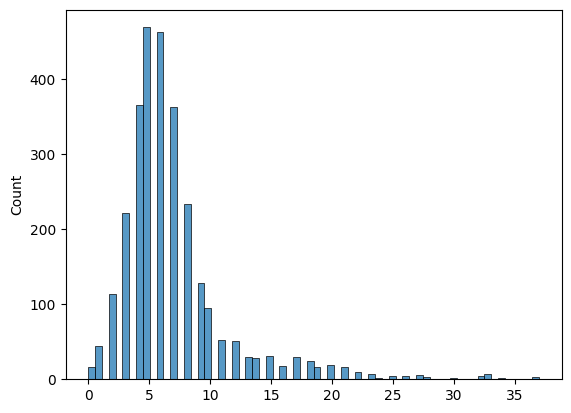

In [16]:
missing_features = df.isnull().sum(axis=1)
sns.histplot(missing_features)

# Предобработка датасета

Все признаки имеют числовой вид, посмотрим на распределение классов

In [17]:
df = df.drop(df[df['bmi']>80].index)

In [18]:
df.loc[df['target'] == 0]['target'].count(), df.loc[df['target'] == 1]['target'].count()

(1871, 1011)

<Axes: xlabel='target', ylabel='Count'>

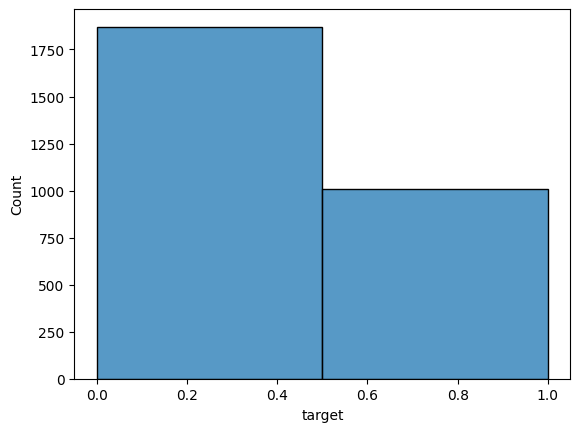

In [19]:
sns.histplot(df['target'], bins = 2)

Классы находятся в соотношении 2:1, будем считать, что они сбалансированы.

Теперь посмотрим на признаки объектов:

In [20]:
df.columns, len(df.columns)

(Index(['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_

Поделим датасет на тренировочную и тестовую выборки, отнормируем их, а затем уже попробуем выбрать наиболее значимые признаки.

<Axes: xlabel='bmi', ylabel='Count'>

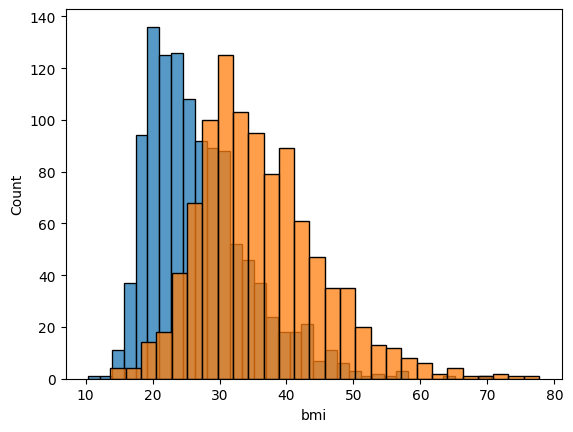

In [21]:
sns.histplot(df[df['target']==0]['bmi'], legend=True)
sns.histplot(df[df['target']==1]['bmi'], legend=True)

In [22]:
df_test = pd.concat([df[df['bmi']<35][df['bmi']>25][df['target']==0].sample(n=216),
                    df[df['bmi']<35][df['bmi']>25][df['target']==1].sample(n=216)])
df_test

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
2307,NaN,NaN,NaN,230.18,16.99,1761.38,46.78,1442.47,1190.68,16.27,10.13,60.64,3.53,2.82,11.31,10.03,2153.49,7.24,1.54,46.76,602.19,0.57,0.15,11.26,2.50,188.21,9.08,256.65,6.53,294.25,1.45,1.17,3.85,1.39,378.01,2.34,84.60,57.93,0.01,4.23,981.81,1.08,0.00,1.36,14.26,4.34,0.00,2.19,80.16,2.22,0.23,0.64,4.91,21.51,2.38,0.87,4.00,4.24,17.84,168.40,75.23,2.68,9.94,1.05,7.45,19.97,105.70,117.38,5.15,8.90,1,0,1,0,28.784129,0
2290,NaN,NaN,NaN,544.42,29.75,2461.11,58.50,1983.31,943.40,19.42,16.89,90.67,4.43,3.75,17.68,27.10,2611.74,36.20,2.12,99.77,796.91,11.52,0.60,39.86,3.33,168.70,14.79,301.14,6.62,778.50,1.34,1.77,4.64,1.52,314.51,3.13,205.12,33.33,NaN,5.55,1297.72,1.26,0.03,1.78,16.48,9.99,0.06,2.78,150.63,3.04,1.12,0.87,17.40,NaN,3.12,3.80,4.00,5.48,18.78,1.47,61.18,20.78,2.82,1.21,22.46,41.90,128.50,109.43,17.09,11.60,1,0,0,0,26.989619,0
1235,NaN,NaN,NaN,325.39,32.63,2033.67,66.51,1535.19,857.22,11.87,8.82,48.20,0.54,0.52,10.14,5.98,1368.74,84.14,0.24,69.78,768.65,NaN,NaN,11.03,0.44,190.88,7.12,175.01,2.03,391.68,0.81,0.90,1.49,0.72,138.65,1.24,62.80,80.23,NaN,0.74,860.32,1.23,0.04,0.25,8.30,2.61,0.00,0.38,17.31,0.39,0.63,0.12,6.48,42.61,0.41,0.33,26.67,0.73,9.43,74.78,43.22,1.62,5.66,0.36,1.85,4.74,22.60,13.35,1.55,2.10,1,0,0,1,31.446090,0
905,NaN,NaN,NaN,302.13,32.00,2320.85,147.04,2004.08,2636.86,24.08,16.37,102.69,5.68,4.37,19.79,12.38,4789.10,8.73,2.72,74.02,960.87,0.11,NaN,35.95,4.04,234.98,14.44,382.72,14.53,2500.34,1.36,1.93,5.16,2.73,355.92,6.31,191.46,NaN,NaN,6.78,1478.73,2.40,NaN,2.23,20.19,6.45,0.00,3.38,252.54,4.02,0.29,0.97,9.88,19.85,3.49,2.26,40.00,6.43,22.72,139.18,127.81,10.94,4.71,1.59,20.09,48.16,95.42,94.82,13.76,16.95,1,0,1,0,26.211051,0
2164,NaN,NaN,NaN,340.13,25.57,2178.01,106.66,1998.45,1610.21,24.85,19.24,74.62,2.76,2.25,14.79,14.52,3583.71,50.35,1.32,77.99,585.22,4.67,0.20,71.49,2.03,251.70,17.86,320.08,24.31,647.16,1.33,1.45,3.21,1.69,254.60,3.22,123.88,199.03,0.17,3.41,1068.98,1.30,NaN,1.04,20.76,11.98,0.01,1.70,103.26,1.87,0.28,0.52,11.03,NaN,1.88,2.92,17.12,3.34,19.55,16.87,31.23,12.96,3.12,1.32,31.94,81.84,75.80,91.44,22.62,7.23,0,1,0,1,31.511111,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,NaN,53.9,32.4,879.03,47.87,3209.27,94.11,2605.19,1615.79,16.49,26.01,120.86,7.10,5.57,18.41,26.47,3373.42,47.08,3.03,127.32,974.40,0.47,0.40,14.73,5.00,220.81,22.27,320.30,10.18,1014.22,1.26,2.14,6.13,1.95,284.00,4.83,190.88,472.00,NaN,8.09,1628.16,1.81,0.19,2.84,20.01,14.78,0.03,4.24,104.28,4.60,1.19,1.19,11.74,NaN,4.37,1.24,NaN,8.10,23.74,6.84,88.14,5.38,3.02,1.31,12.93,32.63,182.07,72.98,9.17,14.40,0,1,1,0,27.896303,1
22,NaN,NaN,NaN,9.33,0.52,11.93,NaN,26.00,7.84,NaN,0.57,2.60,0.25,0.19,0.16,0.05,46.00,NaN,0.14,0.92,1.47,NaN,NaN,NaN,0.18,NaN,0.52,3.20,NaN,0.27,0.01,0.03,0.05,0.05,1.07,0.35,8.76,NaN,NaN,0.31,26.56,0.00,NaN,0.10,0.37,0.04,NaN,0.15,NaN,0.17,NaN,0.05,NaN,NaN,0.16,NaN,NaN,0.29,0.63,NaN,0.27,NaN,0.0

In [23]:
df_train = df.drop(df_test.index)
df_train

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,0.04,0.93,NaN,NaN,0.75,0.08,378.50,NaN,NaN,0.32,19.83,2.25,NaN,NaN,NaN,28.18,0.04,26.83,NaN,8.00,0.06,0.05,0.03,0.04,49.00,NaN,NaN,NaN,NaN,NaN,33.75,0.02,NaN,NaN,0.72,0.06,NaN,NaN,50.00,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,0.66,0.11,NaN,NaN,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,0.02,0.66,NaN,NaN,0.64,0.05,324.95,NaN,NaN,0.19,15.86,0.94,NaN,NaN,NaN,17.79,0.02,23.26,NaN,4.80,0.04,0.06,0.05,0.02,45.40,NaN,NaN,NaN,NaN,NaN,26.08,0.01,NaN,NaN,0.48,0.04,NaN,NaN,30.00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,1.12,0.11,NaN,NaN,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,0.04,1.11,NaN,NaN,1.00,0.08,354.73,NaN,NaN,0.34,25.80,4.77,NaN,NaN,NaN,28.46,0.04,29.70,NaN,8.83,0.07,0.03,0.02,0.05,37.83,NaN,NaN,NaN,NaN,NaN,35.00,0.02,NaN,NaN,0.73,0.06,NaN,NaN,53.22,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,0.11,0.10,NaN,NaN,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,0.03,0.14,0.01,0.01,0.02,0.01,2.45,NaN,0.01,0.22,0.12,NaN,NaN,NaN,0.01,NaN,0.02,0.19,NaN,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.43,NaN,NaN,0.01,1.45,0.00,NaN,0.00,0.02,0.01,NaN,0.01,NaN,0.01,0.00,0.00,0.00,NaN,0.01,NaN,NaN,0.01,0.04,NaN,0.01,NaN,0.00,0.00,NaN,NaN,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,0.05,0.33,0.03,0.02,0.02,0.00,5.97,NaN,0.02,0.10,0.20,NaN,NaN,NaN,0.02,NaN,0.05,0.40,NaN,0.09,0.00,0.00,0.00,0.00,0.10,0.03,0.82,NaN,NaN,0.04,3.32,0.00,NaN,0.01,0.05,0.00,NaN,0.02,NaN,0.02,NaN,0.01,0.00,NaN,0.02,NaN,NaN,0.03,0.07,NaN,0.02,0.01,0.00,0.00,NaN,NaN,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879,18.0,43.3,22.8,148.86,13.66,1495.20,46.12,981.38,792.79,10.46,8.36,30.54,1.16,0.95,8.25,10.06,1370.94,22.00,0.55,45.36,314.95,1.57,1.20,20.88,0.82,119.19,7.66,167.39,4.63,624.41,0.67,0.72,1.72,0.66,134.80,1.20,63.84,124.40,0.02,1.42,519.06,0.77,0.01,0.41,7.36,6.29,0.01,0.72,40.34,0.82,0.32,0.23,6.67,19.18,0.85,0.82,48.00,1.45,10.10,87.20,21.02,4.78,6.31,0.52,3.88,9.44,39.28,45.79,4.36,2.92,1,0,0,1,23.335466,0
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,10.50,55.08,1.96,1.71,11.42,5.57,2305.47,17.34,0.88,56.86,760.68,2.33,0.60,15.07,1.44,163.39,9.33,217.28,8.92,466.08,1.00,1.51,2.84,0.95,218.19,3.14,182.73,62.20,0.02,2.45,961.52,0.84,0.02,0.81,11.14,4.89,0.01,1.30,109.94,1.30,1.29,0.38,3.59,60.64,1.41,0.88,6.67,2.51,10.56,181.60,113.14,4.17,4.55,0.73,9.21,24.18,60.15,68.55,6.56,4.58,1,0,0,1,35.986159,0
2881,36.1,77.1,51.6,1867.95,34.70,3373.56,81.50,2929.34,3550.36,20.59,32.17,185.21,11.50,9.37,27.31,23.95,5804.66,45.02,5.17,104.79,1344.17,8.78,0.25,31.35,8.34,270.83,28.52,534.18,7.92,5607.64,2.03,3.12,10.60,3.72,589.55,30.73,406.35,1249.62,0.33,14.14,2606.66,5.33,0.10,4.66,35.63,13

In [24]:
x_train = df_train.drop(columns=['target'])
y_train = df_train['target']

In [25]:
x_test = df_test.drop(columns=['target'])
y_test = df_test['target']

In [26]:
column_names = x_train.columns

In [27]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_test = pd.DataFrame(scaler.transform(x_test))

In [28]:
column_dict = {a: column_names[a] for a in range(len(x_train.columns))}
column_dict

{0: 'внутриклеточная_жидкость',
 1: 'тощая_мт',
 2: 'акм',
 3: 'холестерин',
 4: 'нас._жир',
 5: 'натрий_na',
 6: 'сахара',
 7: 'энергия',
 8: 'вода',
 9: 'пищ._волокна',
 10: 'мононенас._жир',
 11: 'белки',
 12: 'аргинин',
 13: 'валин',
 14: 'зола',
 15: 'полиненас._жир',
 16: 'калий_k',
 17: 'крахмал',
 18: 'гистидин',
 19: 'жиры',
 20: 'кальций_ca',
 21: 'алкоголь',
 22: 'кремний_si',
 23: 'сера_s',
 24: 'изолейцин',
 25: 'углеводы',
 26: 'олеиновая_кислота',
 27: 'магний_mg',
 28: 'фруктоза',
 29: 'a',
 30: 'b1_тиамин',
 31: 'b2_рибофлав.',
 32: 'b5_пантотен._кис.',
 33: 'b6_пиридоксин',
 34: 'b9_фолаты',
 35: 'b12_кобаламин',
 36: 'b4_холин',
 37: 'β-каротин',
 38: 'ретин._эквив.',
 39: 'лейцин',
 40: 'фосфор_p',
 41: 'омега-3',
 42: 'лактоза',
 43: 'метионин',
 44: 'железо_fe',
 45: 'омега-6',
 46: 'галактоза',
 47: 'метионин+цистеин',
 48: 'c',
 49: 'треонин',
 50: 'd',
 51: 'триптофан',
 52: 'e_α-токоферол',
 53: 'гамма-линолен._к-та',
 54: 'фенилаланин',
 55: 'h_биотин',
 56: 

In [29]:
x_train = x_train.rename(columns=column_dict)
x_test = x_test.rename(columns=column_dict)
x_train

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi
0,NaN,NaN,NaN,NaN,-1.297010,-1.166131,-0.853962,-1.321462,-1.072392,-1.025826,-1.106736,-1.386813,NaN,NaN,-1.380469,-0.945082,-1.198775,NaN,NaN,-1.324410,-1.302877,-0.271868,NaN,NaN,NaN,-1.105509,-1.082260,-1.189882,NaN,-1.011851,-1.066885,-1.402308,-1.241269,-1.356785,-1.204669,NaN,NaN,NaN,NaN,NaN,-1.426777,-1.108713,NaN,NaN,-1.243416,-0.936703,NaN,NaN,-0.692622,NaN,NaN,NaN,-0.866819,NaN,NaN,NaN,NaN,NaN,-1.370714,NaN,NaN,NaN,-0.868120,-1.055785,NaN,NaN,-1.420808,NaN,NaN,-1.250815,-0.910142,-0.284119,-0.460078,-0.682137,NaN
1,NaN,NaN,NaN,NaN,-1.297771,-1.166262,-0.948015,-1.353848,-0.814420,-1.041364,-1.107827,-1.390957,NaN,NaN,-1.388983,-0.946648,-1.219285,NaN,NaN,-1.326186,-1.308993,-0.326101,NaN,NaN,NaN,-1.159894,-1.083445,-1.202273,NaN,-1.015649,-1.081258,-1.394602,-1.236035,-1.371636,-1.221088,NaN,NaN,NaN,NaN,NaN,-1.434775,-1.115250,NaN,NaN,-1.259923,-0.938434,NaN,NaN,-0.832616,NaN,NaN,NaN,-0.868681,NaN,NaN,NaN,NaN,NaN,-1.362310,NaN,NaN,NaN,-0.772937,-1.055785,NaN,NaN,-1.420370,NaN,NaN,-1.253260,-0.910142,-0.284119,-0.460078,-0.682137,NaN
2,NaN,NaN,NaN,NaN,-1.297010,-1.159932,-0.868835,-1.309267,-1.208074,-1.016504,-1.106736,-1.384051,NaN,NaN,-1.361120,-0.945082,-1.207879,NaN,NaN,-1.324137,-1.293680,-0.167542,NaN,NaN,NaN,-1.104044,-1.082260,-1.179920,NaN,-1.010866,-1.059698,-1.417719,-1.243886,-1.349360,-1.255615,NaN,NaN,NaN,NaN,NaN,-1.425474,-1.108713,NaN,NaN,-1.242728,-0.936703,NaN,NaN,-0.670083,NaN,NaN,NaN,-0.866819,NaN,NaN,NaN,NaN,NaN,-1.349002,NaN,NaN,NaN,-0.981927,-1.063767,NaN,NaN,-1.419202,NaN,NaN,-1.239814,1.098730,-0.284119,-0.460078,-0.682137,NaN
3,NaN,NaN,NaN,-1.181943,-1.296250,-1.168937,NaN,-1.402443,-1.623349,NaN,-1.107282,-1.398938,-1.332213,-1.371460,-1.436970,-0.948735,-1.342804,NaN,-1.312130,-1.325776,-1.333243,NaN,NaN,NaN,-1.366007,NaN,-1.083445,-1.282346,NaN,-1.021323,-1.110006,-1.440836,-1.249120,-1.386486,-1.428069,-0.955719,-1.204160,NaN,NaN,-1.352097,-1.460459,-1.121786,NaN,-1.319157,-1.291562,-0.941031,NaN,-1.355639,NaN,-1.354871,-0.385702,-1.369722,-0.871783,NaN,-1.388244,NaN,NaN,-1.368495,-1.394528,NaN,-0.853688,NaN,-1.004688,-1.143580,NaN,NaN,-1.421392,NaN,NaN,-1.267927,-0.910142,-0.284119,-0.460078,-0.682137,NaN
4,NaN,NaN,NaN,-1.180582,-1.296630,-1.170244,NaN,-1.402012,-1.622659,NaN,-1.106190,-1.396022,-1.325584,-1.367170,-1.436970,-0.949257,-1.341456,NaN,-1.304866,-1.327415,-1.333119,NaN,NaN,NaN,-1.361149,NaN,-1.081667,-1.281617,NaN,-1.021239,-1.110006,-1.440836,-1.249120,-1.386486,-1.427704,-0.951427,-1.201544,NaN,NaN,-1.343623,-1.458509,-1.121786,NaN,-1.310441,-1.289498,-0.941897,NaN,-1.349870,NaN,-1.349698,NaN,-1.351062,-0.871783,NaN,-1.383010,NaN,NaN,-1.362653,-1.392426,NaN,-0.853595,-0.791940,-1.004688,-1.143580,NaN,NaN,-1.420078,NaN,NaN,-1.261816,-0.910142,-0.284119,-0.460078,-0.682137,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445,-0.438918,-0.922530,-1.085520,-0.815001,-0.779310,-0.536036,-0.595

Видно, что в датасете есть утечки данных (значения NaN), классический Random Forest Classifier из sklearn.ensemble не может работать с такими данными, поэтому есть несколько вариантов дальнейшей работы:


1.   Работать с моделями, которые поддерживают работу с пропусками в данных
2.   Устранить пропуски при помощи Imputer-а, и обработать его классическим RF

Причем поиск оптимальных параметров для RF будет производиться при помощи GridSearchCV



# Обучение моделей

Для работы с моделями будет использоваться алгоритм кросс-валидации для проверки значений метрик на тренировочной выборке, а итоговые значения метрик будут получаться на тестовой выборке.

Подбор оптимальных параметров происходит при помощи Optuna.

## 1. Рандомный лес

### 1. Imputer + RandomForest

In [86]:
it_imp = SimpleImputer(missing_values=np.nan, strategy='mean')#IterativeImputer(random_state=42)
x_train_imp = it_imp.fit_transform(x_train)
x_test_imp = it_imp.transform(x_test)

In [87]:
def param_search_rf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1)
    }

    model = RandomForestClassifier(**params)
    model.fit(x_train_imp, y_train)
    predictions = model.predict(x_test_imp)
    return f1_score(y_test, predictions)

In [88]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(param_search_rf, n_trials=30)

[I 2024-11-11 09:52:16,703] A new study created in memory with name: no-name-4ecf54a0-a562-4f83-821b-aa643537dc3f
[I 2024-11-11 09:52:20,275] Trial 0 finished with value: 0.44376899696048633 and parameters: {'max_depth': 9, 'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.44376899696048633.
[I 2024-11-11 09:52:23,570] Trial 1 finished with value: 0.3250883392226148 and parameters: {'max_depth': 3, 'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.44376899696048633.
[I 2024-11-11 09:52:25,176] Trial 2 finished with value: 0.42006269592476486 and parameters: {'max_depth': 5, 'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.44376899696048633.
[I 2024-11-11 09:52:29,029] Trial 3 finished with value: 0.33215547703180215 and parameters: {'max_depth': 3, 'n_estimators': 700, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with val

In [89]:
print('Best hyperparameters:', study_rf.best_params)
print('Best ROC-AUC score:', study_rf.best_value)

Best hyperparameters: {'max_depth': 9, 'n_estimators': 700, 'min_samples_split': 8, 'min_samples_leaf': 4}
Best ROC-AUC score: 0.4695121951219512


In [90]:
rfc_best = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                  max_depth = study_rf.best_params['max_depth'],
                                  min_samples_split = study_rf.best_params['min_samples_split'],
                                  min_samples_leaf = study_rf.best_params['min_samples_leaf'],
                                  criterion='log_loss')
rfc_best.fit(x_train_imp, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=9, min_samples_leaf=4,
                       min_samples_split=8, n_estimators=700)

Метрики, получаемые из кросс-валидации

In [91]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(rfc_best, x_train_imp, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([6.38246584, 6.40727901, 6.38083816, 6.36747289, 6.31017447]),
 'score_time': array([0.11397886, 0.12704706, 0.1252296 , 0.12475228, 0.13426828]),
 'test_accuracy': array([0.75306122, 0.81836735, 0.81020408, 0.81428571, 0.78163265]),
 'test_precision_macro': array([0.85416667, 0.8078448 , 0.79120112, 0.78757457, 0.76108156]),
 'test_recall_macro': array([0.62113094, 0.76261187, 0.76147181, 0.80044272, 0.79098026]),
 'test_f1_macro': array([0.61851511, 0.77797464, 0.77271707, 0.79303879, 0.76694774]),
 'test_roc_auc': array([0.91770697, 0.89372779, 0.88046514, 0.86813354, 0.85654297])}

In [92]:
from sklearn.metrics import fbeta_score

def f2_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

In [93]:
def f2_score_on_pr_rec(precision, recall):
  return (5*precision*recall)/(4*precision+recall)

In [94]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
rfc_best_cv_metrics = []
for metric in metrics: rfc_best_cv_metrics.append(scores[metric])
rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
rfc_best_cv_metrics = np.array(rfc_best_cv_metrics)

In [95]:
def report(y_true, y_pred):
  print(classification_report(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred, normalize="all")
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, cmap="Reds")
  print("F2-score: ", f2_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.83      0.67       216
           1       0.67      0.35      0.46       216

    accuracy                           0.59       432
   macro avg       0.61      0.59      0.56       432
weighted avg       0.61      0.59      0.56       432

F2-score:  0.38422131147540983


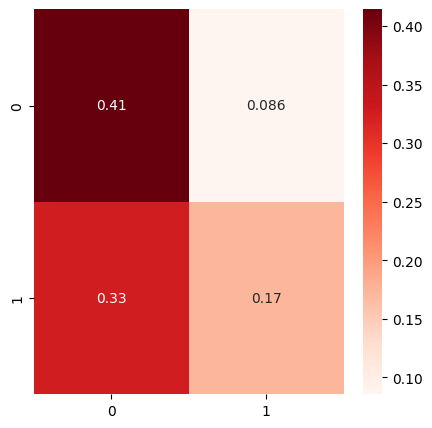

In [96]:
report(y_test, rfc_best.predict(x_test_imp))

### 2. XGBRFClassifier

In [41]:
def param_search_xgbrf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
    }

    model = XGBRFClassifier(**params)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [42]:
study_xgbrf = optuna.create_study(direction='maximize')
study_xgbrf.optimize(param_search_xgbrf, n_trials=30)

[I 2024-11-11 09:37:31,164] A new study created in memory with name: no-name-dc1ba17e-1f91-496e-bb96-4612a087b976


[09:37:31] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:37:39,402] Trial 0 finished with value: 0.5777777777777778 and parameters: {'max_depth': 8, 'n_estimators': 700}. Best is trial 0 with value: 0.5777777777777778.


[09:37:39] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:37:46,355] Trial 1 finished with value: 0.582716049382716 and parameters: {'max_depth': 8, 'n_estimators': 600}. Best is trial 1 with value: 0.582716049382716.


[09:37:46] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:37:52,643] Trial 2 finished with value: 0.5963302752293578 and parameters: {'max_depth': 5, 'n_estimators': 900}. Best is trial 2 with value: 0.5963302752293578.


[09:37:52] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:37:55,663] Trial 3 finished with value: 0.5790754257907542 and parameters: {'max_depth': 7, 'n_estimators': 300}. Best is trial 2 with value: 0.5963302752293578.


[09:37:55] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:37:56,774] Trial 4 finished with value: 0.6214442013129103 and parameters: {'max_depth': 4, 'n_estimators': 200}. Best is trial 4 with value: 0.6214442013129103.


[09:37:56] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:38:03,806] Trial 5 finished with value: 0.583941605839416 and parameters: {'max_depth': 7, 'n_estimators': 700}. Best is trial 4 with value: 0.6214442013129103.


[09:38:03] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:38:09,325] Trial 6 finished with value: 0.5963302752293578 and parameters: {'max_depth': 5, 'n_estimators': 800}. Best is trial 4 with value: 0.6214442013129103.


[09:38:09] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:38:12,802] Trial 7 finished with value: 0.6022988505747128 and parameters: {'max_depth': 5, 'n_estimators': 500}. Best is trial 4 with value: 0.6214442013129103.


[09:38:12] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:38:16,733] Trial 8 finished with value: 0.6311475409836065 and parameters: {'max_depth': 3, 'n_estimators': 1000}. Best is trial 8 with value: 0.6311475409836065.


[09:38:16] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:38:17,824] Trial 9 finished with value: 0.6214442013129103 and parameters: {'max_depth': 4, 'n_estimators': 200}. Best is trial 8 with value: 0.6311475409836065.


[09:38:17] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:38:32,033] Trial 10 finished with value: 0.5945945945945946 and parameters: {'max_depth': 10, 'n_estimators': 1000}. Best is trial 8 with value: 0.6311475409836065.


[09:38:32] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:38:32,559] Trial 11 finished with value: 0.6291666666666665 and parameters: {'max_depth': 3, 'n_estimators': 100}. Best is trial 8 with value: 0.6311475409836065.


[09:38:32] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:38:34,166] Trial 12 finished with value: 0.6278586278586279 and parameters: {'max_depth': 3, 'n_estimators': 400}. Best is trial 8 with value: 0.6311475409836065.


[09:38:34] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:38:34,587] Trial 13 finished with value: 0.6291666666666665 and parameters: {'max_depth': 3, 'n_estimators': 100}. Best is trial 8 with value: 0.6311475409836065.


[09:38:34] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:38:38,535] Trial 14 finished with value: 0.6311475409836065 and parameters: {'max_depth': 3, 'n_estimators': 1000}. Best is trial 8 with value: 0.6311475409836065.


[09:38:38] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:38:43,919] Trial 15 finished with value: 0.6200873362445415 and parameters: {'max_depth': 4, 'n_estimators': 1000}. Best is trial 8 with value: 0.6311475409836065.


[09:38:43] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:38:51,549] Trial 16 finished with value: 0.589622641509434 and parameters: {'max_depth': 6, 'n_estimators': 900}. Best is trial 8 with value: 0.6311475409836065.


[09:38:51] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:38:54,714] Trial 17 finished with value: 0.6324435318275153 and parameters: {'max_depth': 3, 'n_estimators': 800}. Best is trial 17 with value: 0.6324435318275153.


[09:38:54] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:39:06,007] Trial 18 finished with value: 0.5867970660146699 and parameters: {'max_depth': 10, 'n_estimators': 800}. Best is trial 17 with value: 0.6324435318275153.


[09:39:06] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:39:12,836] Trial 19 finished with value: 0.5809523809523809 and parameters: {'max_depth': 6, 'n_estimators': 800}. Best is trial 17 with value: 0.6324435318275153.


[09:39:12] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:39:16,090] Trial 20 finished with value: 0.6184210526315789 and parameters: {'max_depth': 4, 'n_estimators': 600}. Best is trial 17 with value: 0.6324435318275153.


[09:39:16] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:39:20,091] Trial 21 finished with value: 0.6311475409836065 and parameters: {'max_depth': 3, 'n_estimators': 1000}. Best is trial 17 with value: 0.6324435318275153.


[09:39:20] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:39:23,670] Trial 22 finished with value: 0.6311475409836065 and parameters: {'max_depth': 3, 'n_estimators': 900}. Best is trial 17 with value: 0.6324435318275153.


[09:39:23] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:39:29,064] Trial 23 finished with value: 0.6200873362445415 and parameters: {'max_depth': 4, 'n_estimators': 1000}. Best is trial 17 with value: 0.6324435318275153.


[09:39:29] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:39:35,288] Trial 24 finished with value: 0.5963302752293578 and parameters: {'max_depth': 5, 'n_estimators': 900}. Best is trial 17 with value: 0.6324435318275153.


[09:39:35] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:39:38,047] Trial 25 finished with value: 0.6311475409836065 and parameters: {'max_depth': 3, 'n_estimators': 700}. Best is trial 17 with value: 0.6324435318275153.


[09:39:38] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:39:42,407] Trial 26 finished with value: 0.6230936819172114 and parameters: {'max_depth': 4, 'n_estimators': 800}. Best is trial 17 with value: 0.6324435318275153.


[09:39:42] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:39:46,351] Trial 27 finished with value: 0.6311475409836065 and parameters: {'max_depth': 3, 'n_estimators': 1000}. Best is trial 17 with value: 0.6324435318275153.


[09:39:46] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:39:58,024] Trial 28 finished with value: 0.5931372549019609 and parameters: {'max_depth': 9, 'n_estimators': 900}. Best is trial 17 with value: 0.6324435318275153.


[09:39:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:40:03,976] Trial 29 finished with value: 0.5795724465558194 and parameters: {'max_depth': 6, 'n_estimators': 700}. Best is trial 17 with value: 0.6324435318275153.


In [43]:
print('Best hyperparameters:', study_xgbrf.best_params)
print('Best f1 score:', study_xgbrf.best_value)

Best hyperparameters: {'max_depth': 3, 'n_estimators': 800}
Best f1 score: 0.6324435318275153


In [44]:
xgb_rfc_best = XGBRFClassifier(criterion='log_loss', max_depth=study_xgbrf.best_params['max_depth'], n_estimators=study_xgbrf.best_params['n_estimators'])
xgb_rfc_best.fit(x_train, y_train)

[09:40:04] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                criterion='log_loss', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=3, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=800, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None, ...)

In [45]:
scoring = ['accuracy', 'roc_auc','precision_macro', 'recall_macro','f1_macro']
scores = cross_validate(xgb_rfc_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())

[09:40:07] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[09:40:09] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[09:40:11] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[09:40:14] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[09:40:16] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



['fit_time',
 'score_time',
 'test_accuracy',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro',
 'test_roc_auc']

In [46]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_rfc_best_cv_metrics = []
for metric in metrics: xgb_rfc_best_cv_metrics.append(scores[metric])
xgb_rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_rfc_best_cv_metrics  = np.array( xgb_rfc_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.61      0.46      0.53       216
           1       0.57      0.71      0.63       216

    accuracy                           0.59       432
   macro avg       0.59      0.59      0.58       432
weighted avg       0.59      0.59      0.58       432

F2-score:  0.6784140969162995


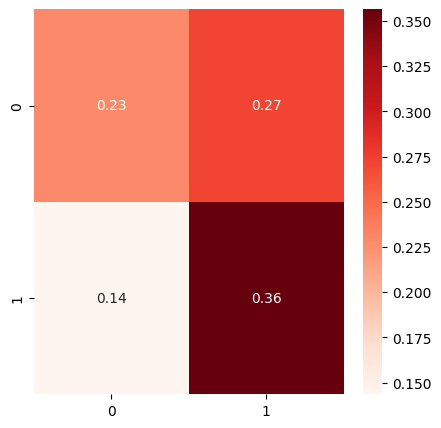

In [47]:
report(y_test, xgb_rfc_best.predict(x_test))

## Бустинги

### Catboost

In [48]:
model = CatBoostClassifier(random_seed=42)

In [49]:
model.fit(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.03954
0:	learn: 0.6693670	test: 0.6876384	best: 0.6876384 (0)	total: 58.1ms	remaining: 58s
200:	learn: 0.2442053	test: 0.6540137	best: 0.6524960 (194)	total: 972ms	remaining: 3.86s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6524960077
bestIteration = 194

Shrink model to first 195 iterations.


In [50]:
f1_score(y_test, model.predict(x_test))

0.6365795724465558

In [51]:
model.get_feature_importance(catboost.Pool(x_train))

array([ 0.90575916,  3.98313607,  0.86482076,  1.40361183,  0.81775065,
        1.00817737,  1.10382967,  0.61697963,  0.78221782,  0.64563712,
        0.58693145,  0.59402026,  0.18171752,  0.34938845,  0.54555959,
        1.52397013,  0.30184568,  1.59808327,  0.8917286 ,  0.61962672,
        0.85353064,  1.37523217,  0.64955407,  0.89879581,  0.65652278,
        0.88918881,  0.90822739,  0.91948762,  0.97353503,  0.36785753,
        0.64505026,  0.74383403,  0.82243797,  1.09505544,  0.8148342 ,
        1.09363551,  1.0152849 ,  3.02461478,  1.63757441,  0.4214044 ,
        0.24849051,  1.2473634 ,  1.68394265,  1.0393231 ,  0.73026735,
        2.10538874,  2.67749051,  0.45391402,  1.16135103,  0.68850065,
        1.63298756,  0.64271313,  1.1248946 ,  0.44916732,  0.34010456,
        0.6768876 ,  0.97796449,  0.82783804,  0.16079811,  1.37850389,
        1.30901829,  0.58352787,  2.01261028,  0.34667288,  0.78136161,
        0.88123   ,  1.21888   ,  0.57923867,  0.41238621,  0.75

In [52]:
def param_search_cb(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_strength": trial.suggest_float("random_strength", 0.5, 2.)
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [53]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(param_search_cb, n_trials=30)

[I 2024-11-11 09:40:21,383] A new study created in memory with name: no-name-2dc748ab-ac51-4978-96d2-14673916b720
[I 2024-11-11 09:40:24,231] Trial 0 finished with value: 0.5530864197530864 and parameters: {'learning_rate': 0.001315331737373291, 'depth': 5, 'subsample': 0.08707159819494191, 'colsample_bylevel': 0.721271837041731, 'min_data_in_leaf': 21, 'random_strength': 1.9955644478706096}. Best is trial 0 with value: 0.5530864197530864.
[I 2024-11-11 09:40:25,616] Trial 1 finished with value: 0.6238095238095239 and parameters: {'learning_rate': 0.009195485830388707, 'depth': 2, 'subsample': 0.8503512118300848, 'colsample_bylevel': 0.982379629471053, 'min_data_in_leaf': 100, 'random_strength': 1.6695614702897632}. Best is trial 1 with value: 0.6238095238095239.
[I 2024-11-11 09:40:28,574] Trial 2 finished with value: 0.5693430656934306 and parameters: {'learning_rate': 0.0013967720206793481, 'depth': 5, 'subsample': 0.1252059769479833, 'colsample_bylevel': 0.8598692776172462, 'min_da

In [54]:
print('Best hyperparameters:', study_cb.best_params)
print('Best f1 score:', study_cb.best_value)

Best hyperparameters: {'learning_rate': 0.015897990597154445, 'depth': 4, 'subsample': 0.8541339485745814, 'colsample_bylevel': 0.7871256259772306, 'min_data_in_leaf': 52, 'random_strength': 1.1727975577638101}
Best f1 score: 0.6318289786223278


In [55]:
cb_best = CatBoostClassifier(learning_rate=study_cb.best_params['learning_rate'],
                             depth=study_cb.best_params['depth'],
                             random_seed=42,
                             subsample=study_cb.best_params['subsample'],
                             colsample_bylevel=study_cb.best_params['colsample_bylevel'],
                             min_data_in_leaf =study_cb.best_params['min_data_in_leaf'],
                             random_strength=study_cb.best_params['random_strength'])
cb_best.fit(x_train, y_train)

0:	learn: 0.6826309	total: 2.24ms	remaining: 2.23s
1:	learn: 0.6726792	total: 4.51ms	remaining: 2.25s
2:	learn: 0.6622070	total: 6.66ms	remaining: 2.21s
3:	learn: 0.6526761	total: 8.8ms	remaining: 2.19s
4:	learn: 0.6447247	total: 10.8ms	remaining: 2.15s
5:	learn: 0.6358322	total: 12.9ms	remaining: 2.14s
6:	learn: 0.6274020	total: 15.1ms	remaining: 2.14s
7:	learn: 0.6192776	total: 17.1ms	remaining: 2.12s
8:	learn: 0.6112201	total: 19.2ms	remaining: 2.12s
9:	learn: 0.6038247	total: 21.3ms	remaining: 2.11s
10:	learn: 0.5963806	total: 23.5ms	remaining: 2.12s
11:	learn: 0.5896409	total: 25.7ms	remaining: 2.11s
12:	learn: 0.5838442	total: 28ms	remaining: 2.13s
13:	learn: 0.5770129	total: 30.3ms	remaining: 2.14s
14:	learn: 0.5699020	total: 32.5ms	remaining: 2.13s
15:	learn: 0.5640109	total: 35.2ms	remaining: 2.16s
16:	learn: 0.5586003	total: 37.3ms	remaining: 2.16s
17:	learn: 0.5523385	total: 39.4ms	remaining: 2.15s
18:	learn: 0.5468574	total: 41.6ms	remaining: 2.15s
19:	learn: 0.5416640	tota

In [56]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(cb_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())
scores

0:	learn: 0.6822647	total: 2.1ms	remaining: 2.1s
1:	learn: 0.6730064	total: 4.22ms	remaining: 2.1s
2:	learn: 0.6625610	total: 6.28ms	remaining: 2.09s
3:	learn: 0.6524929	total: 8.27ms	remaining: 2.06s
4:	learn: 0.6440303	total: 10.2ms	remaining: 2.03s
5:	learn: 0.6349996	total: 12.2ms	remaining: 2.02s
6:	learn: 0.6264697	total: 14.2ms	remaining: 2.01s
7:	learn: 0.6194457	total: 16.1ms	remaining: 2s
8:	learn: 0.6129246	total: 18.2ms	remaining: 2s
9:	learn: 0.6056671	total: 20.1ms	remaining: 1.99s
10:	learn: 0.5988004	total: 21.9ms	remaining: 1.97s
11:	learn: 0.5920231	total: 23.9ms	remaining: 1.97s
12:	learn: 0.5858024	total: 25.9ms	remaining: 1.96s
13:	learn: 0.5791851	total: 28ms	remaining: 1.97s
14:	learn: 0.5724119	total: 29.9ms	remaining: 1.96s
15:	learn: 0.5670162	total: 31.9ms	remaining: 1.96s
16:	learn: 0.5614726	total: 33.8ms	remaining: 1.96s
17:	learn: 0.5561180	total: 35.8ms	remaining: 1.95s
18:	learn: 0.5503870	total: 37.9ms	remaining: 1.96s
19:	learn: 0.5451991	total: 39.9m

{'fit_time': array([2.11023378, 2.1196804 , 2.1288662 , 2.12928891, 2.16618013]),
 'score_time': array([0.01157022, 0.01159906, 0.01172638, 0.01175952, 0.0117209 ]),
 'test_accuracy': array([0.79387755, 0.8244898 , 0.84285714, 0.80612245, 0.74489796]),
 'test_precision_macro': array([0.86153903, 0.80153939, 0.81922878, 0.78286288, 0.75011671]),
 'test_recall_macro': array([0.68729218, 0.79328887, 0.82812708, 0.81074123, 0.78503297]),
 'test_f1_macro': array([0.7068319 , 0.79711122, 0.82330434, 0.7907028 , 0.73809005]),
 'test_roc_auc': array([0.95031257, 0.897927  , 0.89144768, 0.87634194, 0.86059017])}

In [57]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
cb_best_cv_metrics = []
for metric in metrics: cb_best_cv_metrics.append(scores[metric])
cb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
cb_best_cv_metrics = np.array(cb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.63      0.69      0.66       216
           1       0.66      0.60      0.63       216

    accuracy                           0.64       432
   macro avg       0.64      0.64      0.64       432
weighted avg       0.64      0.64      0.64       432

F2-score:  0.6084905660377358


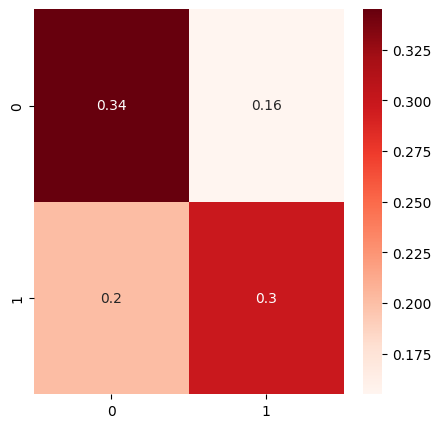

In [58]:
report(y_test, cb_best.predict(x_test))

### XGBoost

In [59]:
model = XGBClassifier()

In [60]:
model.fit(
    x_train,
    y_train,
    )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [61]:
def param_search_xgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [62]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(param_search_xgb, n_trials=30)

[I 2024-11-11 09:42:35,465] A new study created in memory with name: no-name-d81d2be3-afb6-4ca7-8447-02109b3af31d


[09:42:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:42:36,884] Trial 0 finished with value: 0.5748792270531402 and parameters: {'learning_rate': 0.003928293875959535, 'max_depth': 242, 'n_estimators': 100, 'subsample': 0.88403909206826, 'colsample_bylevel': 0.6406201259506957, 'gamma': 1.728733763046534}. Best is trial 0 with value: 0.5748792270531402.


[09:42:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:42:39,233] Trial 1 finished with value: 0.5788113695090438 and parameters: {'learning_rate': 0.005905631854244519, 'max_depth': 456, 'n_estimators': 900, 'subsample': 0.23382976412274908, 'colsample_bylevel': 0.07926575150879869, 'gamma': 2.864011989764642}. Best is trial 1 with value: 0.5788113695090438.


[09:42:39] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:42:43,465] Trial 2 finished with value: 0.5679012345679013 and parameters: {'learning_rate': 0.06425065604500284, 'max_depth': 294, 'n_estimators': 900, 'subsample': 0.3012398344880085, 'colsample_bylevel': 0.6505372556827229, 'gamma': 0.9093741583927164}. Best is trial 1 with value: 0.5788113695090438.


[09:42:43] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:42:44,089] Trial 3 finished with value: 0.598984771573604 and parameters: {'learning_rate': 0.006920467714139335, 'max_depth': 206, 'n_estimators': 100, 'subsample': 0.9548245451024094, 'colsample_bylevel': 0.12836505691921793, 'gamma': 2.6303808857028255}. Best is trial 3 with value: 0.598984771573604.


[09:42:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:42:49,212] Trial 4 finished with value: 0.5764411027568922 and parameters: {'learning_rate': 0.013620721950331118, 'max_depth': 100, 'n_estimators': 800, 'subsample': 0.2774271148959885, 'colsample_bylevel': 0.8543098013089748, 'gamma': 0.23762687228685234}. Best is trial 3 with value: 0.598984771573604.


[09:42:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:00,075] Trial 5 finished with value: 0.6124401913875598 and parameters: {'learning_rate': 0.008121893619746079, 'max_depth': 441, 'n_estimators': 1000, 'subsample': 0.7306461020159067, 'colsample_bylevel': 0.5744970016868927, 'gamma': 1.4454273937107396}. Best is trial 5 with value: 0.6124401913875598.


[09:43:00] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:02,591] Trial 6 finished with value: 0.6164705882352942 and parameters: {'learning_rate': 0.024946036545388878, 'max_depth': 362, 'n_estimators': 500, 'subsample': 0.40625776870077357, 'colsample_bylevel': 0.2838434840550387, 'gamma': 2.8048641507806735}. Best is trial 6 with value: 0.6164705882352942.


[09:43:02] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:08,294] Trial 7 finished with value: 0.6 and parameters: {'learning_rate': 0.06942280638290939, 'max_depth': 419, 'n_estimators': 600, 'subsample': 0.6775829052358304, 'colsample_bylevel': 0.5731536455920119, 'gamma': 2.0232899378565756}. Best is trial 6 with value: 0.6164705882352942.


[09:43:08] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:10,835] Trial 8 finished with value: 0.5925925925925926 and parameters: {'learning_rate': 0.006300056490877938, 'max_depth': 496, 'n_estimators': 900, 'subsample': 0.10546959511112881, 'colsample_bylevel': 0.5968323955031908, 'gamma': 2.6588955670974816}. Best is trial 6 with value: 0.6164705882352942.


[09:43:10] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:12,569] Trial 9 finished with value: 0.6340326340326341 and parameters: {'learning_rate': 0.0030073582252222206, 'max_depth': 266, 'n_estimators': 400, 'subsample': 0.2538665716830556, 'colsample_bylevel': 0.44981243635948687, 'gamma': 1.1392017827329455}. Best is trial 9 with value: 0.6340326340326341.


[09:43:12] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:15,067] Trial 10 finished with value: 0.6146572104018914 and parameters: {'learning_rate': 0.0013205329673205534, 'max_depth': 154, 'n_estimators': 400, 'subsample': 0.509469476612113, 'colsample_bylevel': 0.3409676711672196, 'gamma': 0.7346315747371348}. Best is trial 9 with value: 0.6340326340326341.


[09:43:15] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:17,290] Trial 11 finished with value: 0.5856079404466502 and parameters: {'learning_rate': 0.024107788496474904, 'max_depth': 365, 'n_estimators': 400, 'subsample': 0.4611051228164943, 'colsample_bylevel': 0.31126369096729495, 'gamma': 1.2026143435655923}. Best is trial 9 with value: 0.6340326340326341.


[09:43:17] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:20,060] Trial 12 finished with value: 0.6338028169014085 and parameters: {'learning_rate': 0.002305625715165266, 'max_depth': 349, 'n_estimators': 500, 'subsample': 0.39983171541959855, 'colsample_bylevel': 0.3641972532984864, 'gamma': 2.138890089965054}. Best is trial 9 with value: 0.6340326340326341.


[09:43:20] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:20,672] Trial 13 finished with value: 0.574938574938575 and parameters: {'learning_rate': 0.0016656442968989006, 'max_depth': 304, 'n_estimators': 300, 'subsample': 0.06258534272952945, 'colsample_bylevel': 0.4214429609836035, 'gamma': 2.138554952345521}. Best is trial 9 with value: 0.6340326340326341.


[09:43:20] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:29,131] Trial 14 finished with value: 0.6062052505966588 and parameters: {'learning_rate': 0.0028532756086183278, 'max_depth': 298, 'n_estimators': 600, 'subsample': 0.6408655728644934, 'colsample_bylevel': 0.8529025020321601, 'gamma': 2.2791827033846723}. Best is trial 9 with value: 0.6340326340326341.


[09:43:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:30,691] Trial 15 finished with value: 0.6431924882629108 and parameters: {'learning_rate': 0.0025167098880164306, 'max_depth': 239, 'n_estimators': 300, 'subsample': 0.3434529834428857, 'colsample_bylevel': 0.4109484225135899, 'gamma': 1.4982609463795047}. Best is trial 15 with value: 0.6431924882629108.


[09:43:30] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:31,395] Trial 16 finished with value: 0.6287015945330295 and parameters: {'learning_rate': 0.0010413455197575082, 'max_depth': 223, 'n_estimators': 200, 'subsample': 0.18303675868294955, 'colsample_bylevel': 0.4540965603818985, 'gamma': 0.80798541716827}. Best is trial 15 with value: 0.6431924882629108.


[09:43:31] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:32,625] Trial 17 finished with value: 0.6153846153846153 and parameters: {'learning_rate': 0.0034570897037575796, 'max_depth': 175, 'n_estimators': 300, 'subsample': 0.34414678116657876, 'colsample_bylevel': 0.21843944215221234, 'gamma': 1.5895917071665913}. Best is trial 15 with value: 0.6431924882629108.


[09:43:32] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:40,333] Trial 18 finished with value: 0.5985401459854014 and parameters: {'learning_rate': 0.013947749600952127, 'max_depth': 249, 'n_estimators': 700, 'subsample': 0.5925139589234054, 'colsample_bylevel': 0.7784302351092742, 'gamma': 0.29651117471574473}. Best is trial 15 with value: 0.6431924882629108.


[09:43:40] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:41,328] Trial 19 finished with value: 0.6114942528735632 and parameters: {'learning_rate': 0.0019179384606541879, 'max_depth': 271, 'n_estimators': 300, 'subsample': 0.15998924902696796, 'colsample_bylevel': 0.4761859366671235, 'gamma': 1.1979281071100547}. Best is trial 15 with value: 0.6431924882629108.


[09:43:41] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:42,347] Trial 20 finished with value: 0.6191646191646192 and parameters: {'learning_rate': 0.003991478871507474, 'max_depth': 170, 'n_estimators': 200, 'subsample': 0.549911693529278, 'colsample_bylevel': 0.1698109121868343, 'gamma': 0.5867853627556125}. Best is trial 15 with value: 0.6431924882629108.


[09:43:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:45,039] Trial 21 finished with value: 0.6338028169014085 and parameters: {'learning_rate': 0.0023615892451778055, 'max_depth': 347, 'n_estimators': 500, 'subsample': 0.36778720996018266, 'colsample_bylevel': 0.3832706495374618, 'gamma': 1.860857897214297}. Best is trial 15 with value: 0.6431924882629108.


[09:43:45] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:46,953] Trial 22 finished with value: 0.6038647342995169 and parameters: {'learning_rate': 0.0021469363119973914, 'max_depth': 331, 'n_estimators': 400, 'subsample': 0.4261226436654811, 'colsample_bylevel': 0.24087676226123841, 'gamma': 1.1961736392947153}. Best is trial 15 with value: 0.6431924882629108.


[09:43:46] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:49,075] Trial 23 finished with value: 0.6349206349206349 and parameters: {'learning_rate': 0.0010098115947445073, 'max_depth': 375, 'n_estimators': 500, 'subsample': 0.23356591094406526, 'colsample_bylevel': 0.5028810900157256, 'gamma': 2.392394979644853}. Best is trial 15 with value: 0.6431924882629108.


[09:43:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:52,354] Trial 24 finished with value: 0.6473214285714286 and parameters: {'learning_rate': 0.0011157392872105747, 'max_depth': 417, 'n_estimators': 700, 'subsample': 0.19922865734047357, 'colsample_bylevel': 0.7144537888059888, 'gamma': 1.4051156917279852}. Best is trial 24 with value: 0.6473214285714286.


[09:43:52] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:55,940] Trial 25 finished with value: 0.645879732739421 and parameters: {'learning_rate': 0.0010835304266432685, 'max_depth': 406, 'n_estimators': 700, 'subsample': 0.17153575759613074, 'colsample_bylevel': 0.9746027640796343, 'gamma': 1.5333162869697075}. Best is trial 24 with value: 0.6473214285714286.


[09:43:55] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:43:59,198] Trial 26 finished with value: 0.6414253897550112 and parameters: {'learning_rate': 0.0014106373919646335, 'max_depth': 398, 'n_estimators': 700, 'subsample': 0.14735580649667862, 'colsample_bylevel': 0.9969773726797504, 'gamma': 1.468567666007425}. Best is trial 24 with value: 0.6473214285714286.


[09:43:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:44:00,759] Trial 27 finished with value: 0.5755395683453237 and parameters: {'learning_rate': 0.0013397253002130718, 'max_depth': 461, 'n_estimators': 700, 'subsample': 0.05450410441704781, 'colsample_bylevel': 0.7407478733878062, 'gamma': 1.8154377276247304}. Best is trial 24 with value: 0.6473214285714286.


[09:44:00] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:44:05,235] Trial 28 finished with value: 0.6590909090909091 and parameters: {'learning_rate': 0.0016398825319620777, 'max_depth': 489, 'n_estimators': 800, 'subsample': 0.18675318484800388, 'colsample_bylevel': 0.9870409136665679, 'gamma': 1.564789976044529}. Best is trial 28 with value: 0.6590909090909091.


[09:44:05] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:44:09,466] Trial 29 finished with value: 0.6291079812206574 and parameters: {'learning_rate': 0.004401304423921325, 'max_depth': 490, 'n_estimators': 800, 'subsample': 0.17647499053548887, 'colsample_bylevel': 0.9800800702993907, 'gamma': 1.6479793552860862}. Best is trial 28 with value: 0.6590909090909091.


In [63]:
print('Best hyperparameters:', study_xgb.best_params)
print('Best f1 score:', study_xgb.best_value)

Best hyperparameters: {'learning_rate': 0.0016398825319620777, 'max_depth': 489, 'n_estimators': 800, 'subsample': 0.18675318484800388, 'colsample_bylevel': 0.9870409136665679, 'gamma': 1.564789976044529}
Best f1 score: 0.6590909090909091


In [64]:
xgb_best = XGBClassifier(learning_rate=study_xgb.best_params['learning_rate'],
                         max_depth=study_xgb.best_params['max_depth'],
                         n_estimators = study_xgb.best_params['n_estimators'],
                         random_seed=42,
                         subsample=study_xgb.best_params['subsample'],
                         colsample_bylevel= study_xgb.best_params['colsample_bylevel'],
                         gamma=study_xgb.best_params['gamma'])
xgb_best.fit(x_train, y_train)

[09:44:09] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.9870409136665679, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.564789976044529, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0016398825319620777, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=489, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=42, ...)

In [65]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(xgb_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())
scores

[09:44:13] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[09:44:16] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[09:44:20] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[09:44:23] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[09:44:27] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



{'fit_time': array([2.87188148, 3.52756691, 3.50884891, 3.45524621, 3.41229153]),
 'score_time': array([0.01994252, 0.01965427, 0.01979375, 0.01875401, 0.01887441]),
 'test_accuracy': array([0.80612245, 0.84285714, 0.83877551, 0.80816327, 0.73469388]),
 'test_precision_macro': array([0.87510454, 0.82273824, 0.81427331, 0.78586307, 0.74068144]),
 'test_recall_macro': array([0.70452602, 0.81505444, 0.83000817, 0.81551996, 0.77421194]),
 'test_f1_macro': array([0.72766789, 0.81865721, 0.82084924, 0.79363799, 0.72779639]),
 'test_roc_auc': array([0.91994908, 0.89977009, 0.88137719, 0.87991412, 0.83778905])}

In [66]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_best_cv_metrics = []
for metric in metrics: xgb_best_cv_metrics.append(scores[metric])
xgb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_best_cv_metrics = np.array(xgb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.66      0.63      0.65       216
           1       0.65      0.67      0.66       216

    accuracy                           0.65       432
   macro avg       0.65      0.65      0.65       432
weighted avg       0.65      0.65      0.65       432

F2-score:  0.6663602941176471


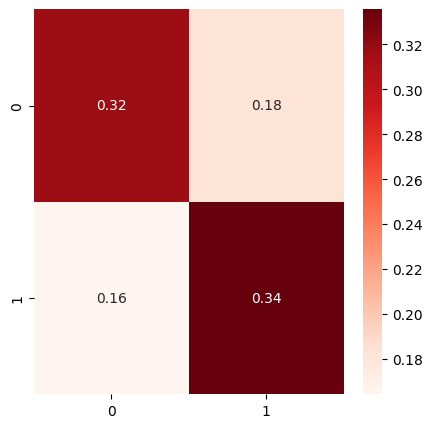

In [67]:
report(y_test, xgb_best.predict(x_test))

### LightGBM

In [68]:
model = LGBMClassifier()

In [69]:
model.fit(
    x_train,
    y_train,
    )

LGBMClassifier()

In [70]:
def param_search_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [71]:
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(param_search_lgbm, n_trials=30)

[I 2024-11-11 09:44:31,519] A new study created in memory with name: no-name-22dc6518-7ac0-4ae7-9853-a39b5966de76


[09:44:31] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:44:33,983] Trial 0 finished with value: 0.641860465116279 and parameters: {'learning_rate': 0.0011706169917854727, 'max_depth': 158, 'n_estimators': 700, 'subsample': 0.19464221600242732, 'colsample_bylevel': 0.41361461212228945, 'gamma': 0.667648340374646}. Best is trial 0 with value: 0.641860465116279.


[09:44:33] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:44:37,975] Trial 1 finished with value: 0.5800000000000001 and parameters: {'learning_rate': 0.04511063740397288, 'max_depth': 280, 'n_estimators': 700, 'subsample': 0.7260208432670263, 'colsample_bylevel': 0.16946366629925452, 'gamma': 2.5934480251907135}. Best is trial 0 with value: 0.641860465116279.


[09:44:37] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:44:41,314] Trial 2 finished with value: 0.5851318944844125 and parameters: {'learning_rate': 0.050928845459778174, 'max_depth': 216, 'n_estimators': 300, 'subsample': 0.5096216919853435, 'colsample_bylevel': 0.896674961369407, 'gamma': 1.8691058224614425}. Best is trial 0 with value: 0.641860465116279.


[09:44:41] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:44:42,737] Trial 3 finished with value: 0.6037735849056604 and parameters: {'learning_rate': 0.05181338250900852, 'max_depth': 459, 'n_estimators': 100, 'subsample': 0.8173110488814415, 'colsample_bylevel': 0.7139921669498275, 'gamma': 1.5215488776858102}. Best is trial 0 with value: 0.641860465116279.


[09:44:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:44:43,660] Trial 4 finished with value: 0.6084905660377359 and parameters: {'learning_rate': 0.005286079933406293, 'max_depth': 225, 'n_estimators': 100, 'subsample': 0.7561375495061665, 'colsample_bylevel': 0.4098388316524656, 'gamma': 1.7576216319314455}. Best is trial 0 with value: 0.641860465116279.


[09:44:43] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:44:48,301] Trial 5 finished with value: 0.5936739659367396 and parameters: {'learning_rate': 0.0012142835760926855, 'max_depth': 260, 'n_estimators': 400, 'subsample': 0.5211696200496199, 'colsample_bylevel': 0.835139870831699, 'gamma': 1.8717395408886983}. Best is trial 0 with value: 0.641860465116279.


[09:44:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:44:52,857] Trial 6 finished with value: 0.5831325301204819 and parameters: {'learning_rate': 0.06117113917437939, 'max_depth': 406, 'n_estimators': 400, 'subsample': 0.5313688287543598, 'colsample_bylevel': 0.903043042334711, 'gamma': 2.3005621533977973}. Best is trial 0 with value: 0.641860465116279.


[09:44:52] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:44:59,807] Trial 7 finished with value: 0.6112469437652811 and parameters: {'learning_rate': 0.013380979455656099, 'max_depth': 454, 'n_estimators': 800, 'subsample': 0.7472827366047881, 'colsample_bylevel': 0.42879461604923147, 'gamma': 0.9824052416039973}. Best is trial 0 with value: 0.641860465116279.


[09:44:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:45:02,750] Trial 8 finished with value: 0.6218097447795824 and parameters: {'learning_rate': 0.00538449535792227, 'max_depth': 148, 'n_estimators': 400, 'subsample': 0.27446589568879104, 'colsample_bylevel': 0.9491556155841591, 'gamma': 0.30438439782271287}. Best is trial 0 with value: 0.641860465116279.


[09:45:02] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:45:05,443] Trial 9 finished with value: 0.6039603960396039 and parameters: {'learning_rate': 0.03168229375948493, 'max_depth': 234, 'n_estimators': 600, 'subsample': 0.36037024290002967, 'colsample_bylevel': 0.28757903943453145, 'gamma': 2.898158337898806}. Best is trial 0 with value: 0.641860465116279.


[09:45:05] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:45:08,330] Trial 10 finished with value: 0.6261682242990654 and parameters: {'learning_rate': 0.001008199830819232, 'max_depth': 107, 'n_estimators': 1000, 'subsample': 0.11427779710041176, 'colsample_bylevel': 0.565111421787379, 'gamma': 0.14695851286316597}. Best is trial 0 with value: 0.641860465116279.


[09:45:08] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:45:10,684] Trial 11 finished with value: 0.5865384615384615 and parameters: {'learning_rate': 0.001222579309446835, 'max_depth': 108, 'n_estimators': 1000, 'subsample': 0.07190384380826303, 'colsample_bylevel': 0.6014945093998753, 'gamma': 0.19402716953133758}. Best is trial 0 with value: 0.641860465116279.


[09:45:10] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:45:13,461] Trial 12 finished with value: 0.6346153846153846 and parameters: {'learning_rate': 0.0024759219093591486, 'max_depth': 154, 'n_estimators': 1000, 'subsample': 0.102293911692028, 'colsample_bylevel': 0.5656723511834091, 'gamma': 0.7555297138093183}. Best is trial 0 with value: 0.641860465116279.


[09:45:13] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:45:15,582] Trial 13 finished with value: 0.5439999999999999 and parameters: {'learning_rate': 0.0025072993963057943, 'max_depth': 348, 'n_estimators': 800, 'subsample': 0.2310254268154061, 'colsample_bylevel': 0.09475689684778021, 'gamma': 0.8477833542206172}. Best is trial 0 with value: 0.641860465116279.


[09:45:15] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:45:18,622] Trial 14 finished with value: 0.620525059665871 and parameters: {'learning_rate': 0.002664015422280826, 'max_depth': 165, 'n_estimators': 900, 'subsample': 0.18457650748382406, 'colsample_bylevel': 0.38966035174425934, 'gamma': 0.8344111296650296}. Best is trial 0 with value: 0.641860465116279.


[09:45:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:45:22,991] Trial 15 finished with value: 0.6344827586206897 and parameters: {'learning_rate': 0.002468496186140394, 'max_depth': 173, 'n_estimators': 600, 'subsample': 0.35122523335277256, 'colsample_bylevel': 0.6848030202303401, 'gamma': 1.2160313116813632}. Best is trial 0 with value: 0.641860465116279.


[09:45:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:45:24,400] Trial 16 finished with value: 0.5699745547073791 and parameters: {'learning_rate': 0.010577865903834135, 'max_depth': 311, 'n_estimators': 800, 'subsample': 0.05896182739951819, 'colsample_bylevel': 0.2741072944633256, 'gamma': 0.6190310428123044}. Best is trial 0 with value: 0.641860465116279.


[09:45:24] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:45:35,230] Trial 17 finished with value: 0.5975903614457831 and parameters: {'learning_rate': 0.004905755696976328, 'max_depth': 196, 'n_estimators': 900, 'subsample': 0.9895608672896868, 'colsample_bylevel': 0.49079326086527775, 'gamma': 0.5605893767654666}. Best is trial 0 with value: 0.641860465116279.


[09:45:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:45:40,903] Trial 18 finished with value: 0.625 and parameters: {'learning_rate': 0.0018977070900392014, 'max_depth': 140, 'n_estimators': 700, 'subsample': 0.38965044027097323, 'colsample_bylevel': 0.7183326812097537, 'gamma': 1.2253609402582968}. Best is trial 0 with value: 0.641860465116279.


[09:45:40] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:45:43,988] Trial 19 finished with value: 0.5707070707070707 and parameters: {'learning_rate': 0.01733095936980097, 'max_depth': 331, 'n_estimators': 1000, 'subsample': 0.2172587215111131, 'colsample_bylevel': 0.3019301713961691, 'gamma': 0.5406427649753666}. Best is trial 0 with value: 0.641860465116279.


[09:45:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:45:45,782] Trial 20 finished with value: 0.6340326340326341 and parameters: {'learning_rate': 0.0035089614887817942, 'max_depth': 356, 'n_estimators': 500, 'subsample': 0.1474074776957207, 'colsample_bylevel': 0.6198374852169737, 'gamma': 1.2873221146011453}. Best is trial 0 with value: 0.641860465116279.


[09:45:45] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:45:49,800] Trial 21 finished with value: 0.6463700234192038 and parameters: {'learning_rate': 0.0017720042379928706, 'max_depth': 179, 'n_estimators': 600, 'subsample': 0.3220942622405206, 'colsample_bylevel': 0.6876401906379651, 'gamma': 1.1837296608861028}. Best is trial 21 with value: 0.6463700234192038.


[09:45:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:45:54,520] Trial 22 finished with value: 0.6451612903225807 and parameters: {'learning_rate': 0.0016476218198851116, 'max_depth': 193, 'n_estimators': 700, 'subsample': 0.2897208558322676, 'colsample_bylevel': 0.7798770778993886, 'gamma': 1.004972176413931}. Best is trial 21 with value: 0.6463700234192038.


[09:45:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:46:01,223] Trial 23 finished with value: 0.6296296296296297 and parameters: {'learning_rate': 0.0015650016422449333, 'max_depth': 196, 'n_estimators': 700, 'subsample': 0.4367680845600038, 'colsample_bylevel': 0.7774928904114456, 'gamma': 1.0953940961183652}. Best is trial 21 with value: 0.6463700234192038.


[09:46:01] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:46:04,852] Trial 24 finished with value: 0.6327944572748269 and parameters: {'learning_rate': 0.0016510325117396539, 'max_depth': 264, 'n_estimators': 500, 'subsample': 0.3095078897166606, 'colsample_bylevel': 0.805960572908303, 'gamma': 1.5746712533715774}. Best is trial 21 with value: 0.6463700234192038.


[09:46:04] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:46:09,077] Trial 25 finished with value: 0.6214953271028036 and parameters: {'learning_rate': 0.0035396364662473017, 'max_depth': 131, 'n_estimators': 600, 'subsample': 0.44027524174028837, 'colsample_bylevel': 0.48702273625943904, 'gamma': 1.4430817140493628}. Best is trial 21 with value: 0.6463700234192038.


[09:46:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:46:16,656] Trial 26 finished with value: 0.6128266033254156 and parameters: {'learning_rate': 0.006408750233153312, 'max_depth': 188, 'n_estimators': 700, 'subsample': 0.6166848534211653, 'colsample_bylevel': 0.6537995231864657, 'gamma': 0.4213026405986243}. Best is trial 21 with value: 0.6463700234192038.


[09:46:16] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:46:19,648] Trial 27 finished with value: 0.6502242152466366 and parameters: {'learning_rate': 0.0015116500986376159, 'max_depth': 246, 'n_estimators': 500, 'subsample': 0.25419244211615216, 'colsample_bylevel': 0.775367982492354, 'gamma': 0.8519471188510598}. Best is trial 27 with value: 0.6502242152466366.


[09:46:19] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:46:21,421] Trial 28 finished with value: 0.5566502463054187 and parameters: {'learning_rate': 0.0871595212619596, 'max_depth': 244, 'n_estimators': 300, 'subsample': 0.2941406382165548, 'colsample_bylevel': 0.7887883382832226, 'gamma': 0.9133122504761643}. Best is trial 27 with value: 0.6502242152466366.


[09:46:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:46:24,342] Trial 29 finished with value: 0.6048780487804879 and parameters: {'learning_rate': 0.007709551069456571, 'max_depth': 290, 'n_estimators': 500, 'subsample': 0.2200649426293262, 'colsample_bylevel': 0.8810664013095618, 'gamma': 1.06935191069182}. Best is trial 27 with value: 0.6502242152466366.


In [72]:
print('Best hyperparameters:', study_lgbm.best_params)
print('Best f1 score:', study_lgbm.best_value)

Best hyperparameters: {'learning_rate': 0.0015116500986376159, 'max_depth': 246, 'n_estimators': 500, 'subsample': 0.25419244211615216, 'colsample_bylevel': 0.775367982492354, 'gamma': 0.8519471188510598}
Best f1 score: 0.6502242152466366


In [73]:
lgbm_best = LGBMClassifier(learning_rate=study_lgbm.best_params['learning_rate'],
                             max_depth=study_lgbm.best_params['max_depth'],
                             n_estimators = study_lgbm.best_params['n_estimators'],
                             random_seed=42,
                             subsample=study_lgbm.best_params['subsample'])
lgbm_best.fit(x_train, y_train)

LGBMClassifier(learning_rate=0.0015116500986376159, max_depth=246,
               n_estimators=500, random_seed=42, subsample=0.25419244211615216)

In [74]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(lgbm_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([1.05210447, 1.18609762, 1.19327641, 1.25867772, 1.27098131]),
 'score_time': array([0.01451683, 0.01454663, 0.01454043, 0.01470447, 0.0139935 ]),
 'test_accuracy': array([0.72857143, 0.77959184, 0.80612245, 0.79795918, 0.78163265]),
 'test_precision_macro': array([0.83928571, 0.7798342 , 0.7989418 , 0.77486165, 0.75743739]),
 'test_recall_macro': array([0.58339509, 0.69305896, 0.74047578, 0.74914021, 0.78280986]),
 'test_f1_macro': array([0.56052626, 0.7100274 , 0.75772748, 0.75900562, 0.76426526]),
 'test_roc_auc': array([0.88631743, 0.88414182, 0.89058314, 0.87383382, 0.84132322])}

In [75]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
lgbm_best_cv_metrics = []
for metric in metrics: lgbm_best_cv_metrics.append(scores[metric])
lgbm_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
lgbm_best_cv_metrics = np.array(lgbm_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.54      0.88      0.67       216
           1       0.68      0.26      0.38       216

    accuracy                           0.57       432
   macro avg       0.61      0.57      0.52       432
weighted avg       0.61      0.57      0.52       432

F2-score:  0.2959830866807611


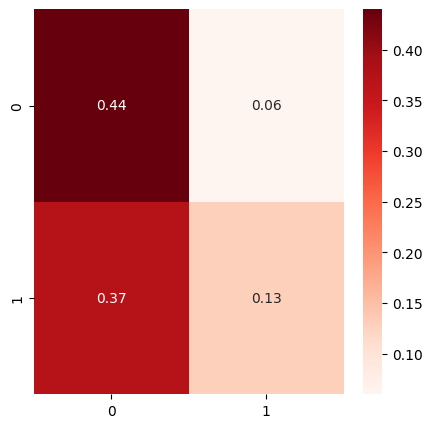

In [76]:
report(y_test, lgbm_best.predict(x_test))

# Результаты

In [97]:
best_models = [rfc_best, xgb_rfc_best, xgb_best, lgbm_best, cb_best]

In [98]:
best_models_cv_metrics = [rfc_best_cv_metrics, xgb_rfc_best_cv_metrics, xgb_best_cv_metrics, lgbm_best_cv_metrics, cb_best_cv_metrics]

In [99]:
def test_results(model, x_test, y_true):
  y_pred = model.predict(x_test)
  round_num = 2
  result_dict = {
      "Accuracy": round(accuracy_score(y_true, y_pred), round_num),
      "AUC": round(roc_auc_score(y_true, y_pred), round_num),
      "Precision": round(precision_score(y_true, y_pred), round_num),
      "Recall": round(recall_score(y_true, y_pred), round_num),
      "F1-score": round(f1_score(y_true, y_pred), round_num),
      "F2-score": round(f2_score(y_true, y_pred), round_num)
  }
  return result_dict

In [100]:
round_num = 2
for metrics in best_models_cv_metrics:
  print("'Accuracy':", round(np.mean(metrics[0]), round_num),"+-",round(np.std(metrics[0]), round_num),",",
        "'AUC':", round(np.mean(metrics[1]), round_num),"+-",round(np.std(metrics[1]), round_num),","
        "'Precision':", round(np.mean(metrics[2]), round_num),"+-",round(np.std(metrics[2]), round_num),","
        "'Recall':", round(np.mean(metrics[3]), round_num),"+-",round(np.std(metrics[3]), round_num),","
        "'F1-score':", round(np.mean(metrics[4]), round_num),"+-",round(np.std(metrics[4]), round_num),","
        "'F2-score':", round(np.mean(metrics[5]), round_num),"+-",round(np.std(metrics[5]), round_num),)

'Accuracy': 0.8 +- 0.02 , 'AUC': 0.88 +- 0.02 ,'Precision': 0.8 +- 0.03 ,'Recall': 0.75 +- 0.06 ,'F1-score': 0.75 +- 0.06 ,'F2-score': 0.76 +- 0.05
'Accuracy': 0.81 +- 0.05 , 'AUC': 0.89 +- 0.03 ,'Precision': 0.8 +- 0.05 ,'Recall': 0.8 +- 0.02 ,'F1-score': 0.79 +- 0.04 ,'F2-score': 0.8 +- 0.02
'Accuracy': 0.81 +- 0.04 , 'AUC': 0.88 +- 0.03 ,'Precision': 0.81 +- 0.04 ,'Recall': 0.79 +- 0.05 ,'F1-score': 0.78 +- 0.04 ,'F2-score': 0.79 +- 0.04
'Accuracy': 0.78 +- 0.03 , 'AUC': 0.88 +- 0.02 ,'Precision': 0.79 +- 0.03 ,'Recall': 0.71 +- 0.07 ,'F1-score': 0.71 +- 0.08 ,'F2-score': 0.72 +- 0.06
'Accuracy': 0.8 +- 0.03 , 'AUC': 0.9 +- 0.03 ,'Precision': 0.8 +- 0.04 ,'Recall': 0.78 +- 0.05 ,'F1-score': 0.77 +- 0.04 ,'F2-score': 0.78 +- 0.04


In [101]:
for model in best_models:
  if model == rfc_best: print(test_results(model, x_test_imp, y_test))
  else: print(test_results(model, x_test, y_test))

{'Accuracy': 0.59, 'AUC': 0.59, 'Precision': 0.67, 'Recall': 0.35, 'F1-score': 0.46, 'F2-score': 0.38}
{'Accuracy': 0.59, 'AUC': 0.59, 'Precision': 0.57, 'Recall': 0.71, 'F1-score': 0.63, 'F2-score': 0.68}
{'Accuracy': 0.65, 'AUC': 0.65, 'Precision': 0.65, 'Recall': 0.67, 'F1-score': 0.66, 'F2-score': 0.67}
{'Accuracy': 0.57, 'AUC': 0.57, 'Precision': 0.68, 'Recall': 0.26, 'F1-score': 0.38, 'F2-score': 0.3}
{'Accuracy': 0.64, 'AUC': 0.64, 'Precision': 0.66, 'Recall': 0.6, 'F1-score': 0.63, 'F2-score': 0.61}


In [102]:
from catboost import CatBoostClassifier, CatBoostRegressor
import shap
shap.initjs()

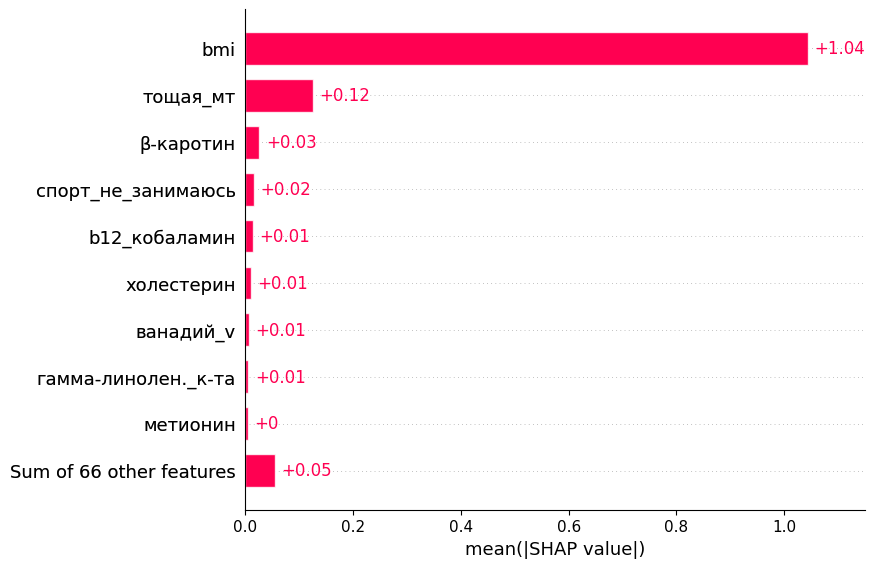

In [104]:
explainer = shap.TreeExplainer(xgb_rfc_best)
shap_values = explainer(x_train)

# visualize the first prediction's explanation
#shap.plots.force(shap_values)
shap.plots.bar(shap_values)